In [1]:
pip install PyWavelets

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import librosa.display
from sklearn.preprocessing import StandardScaler
import pywt
import IPython

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [3]:
audio, sr = librosa.load("./Audios/Benjamin_Netanyau/1.wav")

In [4]:
recortado_path = './Audios/Julia_Gillard/1.wav'
IPython.display.Audio(recortado_path)


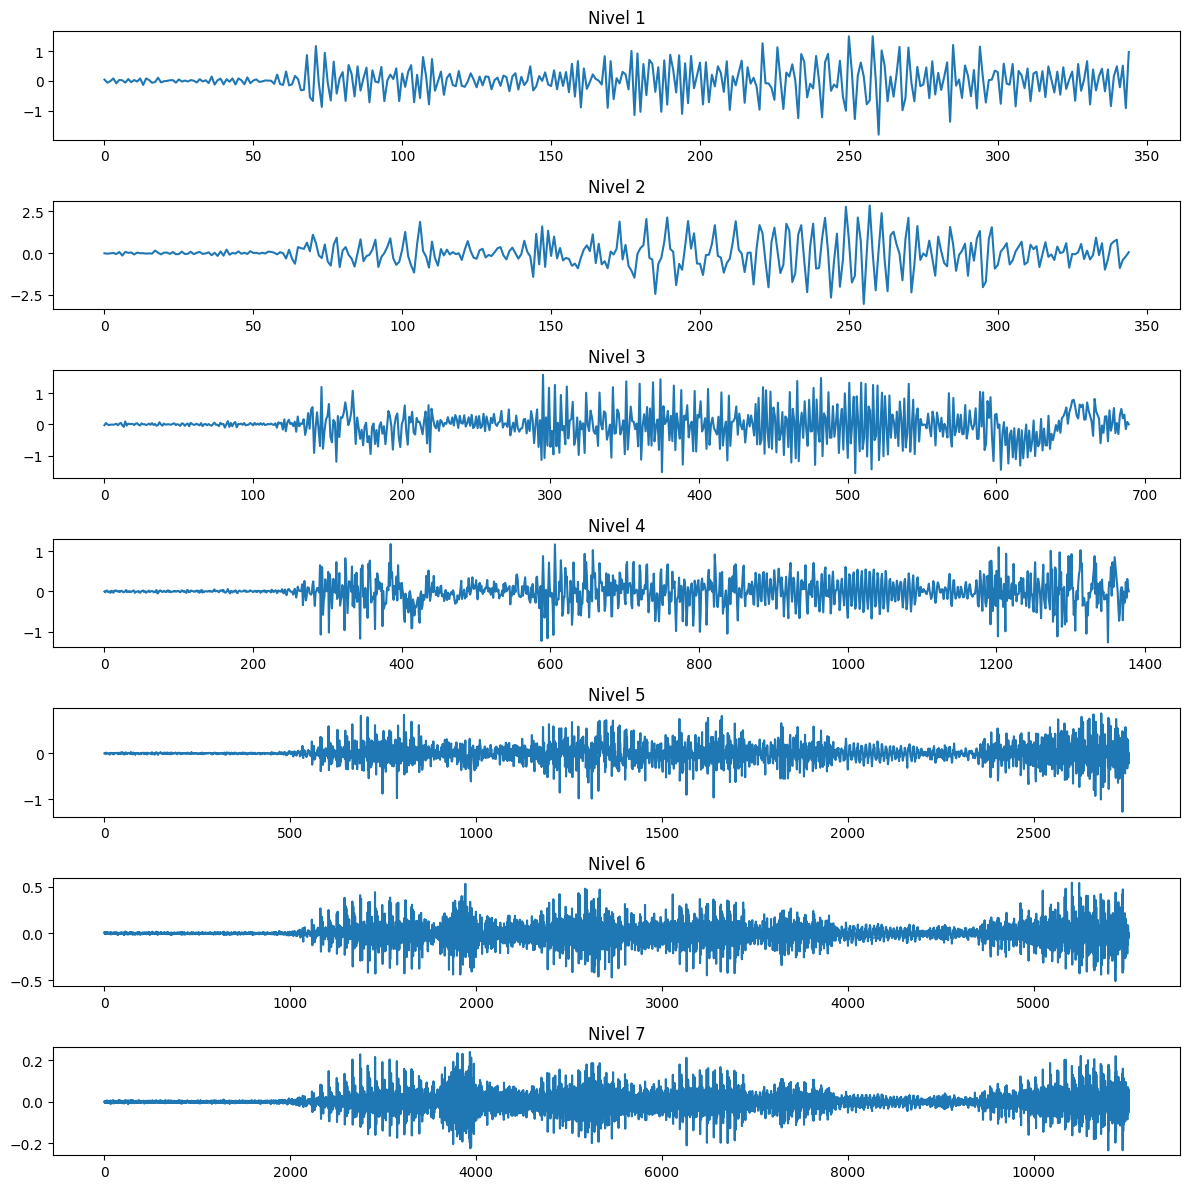

In [5]:
coeffs = pywt.wavedec(audio, 'db1', level=6)
# Visualización de la descomposición
fig, axs = plt.subplots(len(coeffs), 1, figsize=(12, 12))
for i, coeff in enumerate(coeffs):
    axs[i].plot(coeff)
    axs[i].set_title(f'Nivel {i+1}')
plt.tight_layout()
plt.show()

In [6]:
mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

In [7]:
# Normalize MFCC features
mfccs = StandardScaler().fit_transform(mfccs)

In [8]:
mfccs.shape

(13, 44)

In [9]:
coeffs_list = []

In [10]:
coeffs = pywt.wavedec(audio, 'db1', level=10)
coeffs_flattened = np.concatenate(coeffs)
coeffs_list.append(coeffs_flattened)

In [11]:
len(np.array(coeffs_list)[0])

22057

In [12]:
# Output directory to clear
ruta = "./Audios"

speaker_folders = [
    "Benjamin_Netanyau",
    "Jens_Stoltenberg",
    "Julia_Gillard",
    "Magaret_Tarcher",
    "Nelson_Mandela"
]

speaker_folders2 = [
    "Prueba"
]

In [13]:
def extract_features(parent_dir, speaker_folders):
    features = []
    labels = []

    for i, speaker_folder in enumerate(speaker_folders):
        speaker_folder_path = os.path.join(parent_dir, speaker_folder)

        for filename in os.listdir(speaker_folder_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(speaker_folder_path, filename)
                audio, sr = librosa.load(file_path, sr=None, duration=1)
                coeffs = pywt.wavedec(audio, 'db1', level=10)
                # Encontrar la longitud máxima de los coeficientes
                max_length = max(len(coeff) for coeff in coeffs)

                feature = []

                # Rellenar los coeficientes para que tengan la misma longitud
                for coeff in coeffs:
                    padded_coeff = np.pad(coeff, (0, max_length - len(coeff)), 'constant')
                    feature.append(padded_coeff)
                
                features.append(np.array(feature).T)
                labels.append(i)

    return np.array(features), np.array(labels)

In [14]:
X, y = extract_features(ruta, speaker_folders)

In [15]:
for feature in X[:1]:
    print(feature)

[[-0.00295066  0.00703621  0.00794654 ... -0.00376557  0.00753784
   0.00364688]
 [ 0.01310062 -0.00522708 -0.00366037 ... -0.00604217 -0.00160217
  -0.00507111]
 [ 0.01706887 -0.03678514 -0.01217066 ... -0.01865521 -0.00767517
  -0.00474742]
 ...
 [ 0.          0.          0.         ...  0.          0.
  -0.03860516]
 [ 0.          0.          0.         ...  0.          0.
  -0.04214416]
 [ 0.          0.          0.         ...  0.          0.
   0.05310638]]


In [16]:
import tensorflow as tf

In [17]:
from sklearn.preprocessing import LabelEncoder
# Encode labels with explicit classes
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
label_encoder.classes_ = np.array(speaker_folders)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shapes of training and validation data
print("Training Data Shape:", X_train.shape)
print("Validation Data Shape:", X_val.shape)

Training Data Shape: (5247, 8000, 11)
Validation Data Shape: (1124, 8000, 11)


In [30]:
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (5247, 8000, 11)
X_val shape: (1124, 8000, 11)
y_train shape: (5247, 5)
y_val shape: (1124, 5)


In [31]:
# Verificar y transformar etiquetas a one-hot encoding si no lo están ya
num_classes = y_val.shape[1]
if y_train.ndim == 1:
    y_train = to_categorical(y_train, num_classes=num_classes)
if y_val.ndim == 1:
    y_val = to_categorical(y_val, num_classes=num_classes)

In [32]:
# Asegúrate de que las entradas tengan la forma correcta
input_shape = (X_train.shape[1], X_train.shape[2], 1)

In [33]:
# Redimensionar los datos para incluir el canal
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2], 1))

In [40]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

# Supongamos que X_train es tu conjunto de entrenamiento y speaker_folders contiene las clases
input_shape = (X_train.shape[1], X_train.shape[2], 1)  # Asegúrate de que esto coincida con tus datos
num_classes = len(speaker_folders)

model = Sequential()

# Capa convolucional 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Capa convolucional 2
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Capa convolucional 3
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Aplanamiento
model.add(Flatten())

# Capa completamente conectada
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Regularización para prevenir el sobreajuste
model.add(Dense(num_classes, activation='softmax'))  # Número de clases

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 8000, 11, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 4000, 5, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 4000, 5, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 2000, 2, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 2000, 2, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 1000, 1, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 128000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    16,384,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,477,445 (62.86 MB)

 Trainable params: 16,477,445 (62.86 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
from tensorflow.keras.callbacks import EarlyStopping
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [42]:
# Train the model with EarlyStopping
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, callbacks=[early_stopping])

Epoch 1/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 345s 2s/step - accuracy: 0.4200 - loss: 1.3006 - val_accuracy: 0.7180 - val_loss: 0.7004
Epoch 2/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - accuracy: 0.7047 - loss: 0.7277 - val_accuracy: 0.8043 - val_loss: 0.4849
Epoch 3/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - accuracy: 0.7934 - loss: 0.5162 - val_accuracy: 0.8701 - val_loss: 0.3626
Epoch 4/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 331s 2s/step - accuracy: 0.8514 - loss: 0.3976 - val_accuracy: 0.8603 - val_loss: 0.3600
Epoch 5/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.8637 - loss: 0.3580 - val_accuracy: 0.8719 - val_loss: 0.3154
Epoch 6/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - accuracy: 0.8986 - loss: 0.2722 - val_accuracy: 0.9057 - val_loss: 0.2162
Epoch 7/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.9135 - loss: 0.2184 - val_accuracy: 0.8559 - val_loss: 0.3729
Epoch 8/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 333s 2s/step - accuracy: 0.9195 - loss: 0.1985 - val_accu

In [43]:
# Check if EarlyStopping triggered
if early_stopping.stopped_epoch > 0:
    print("Early stopping triggered at epoch", early_stopping.stopped_epoch + 1)
else:
    print("Training completed without early stopping")

Early stopping triggered at epoch 8


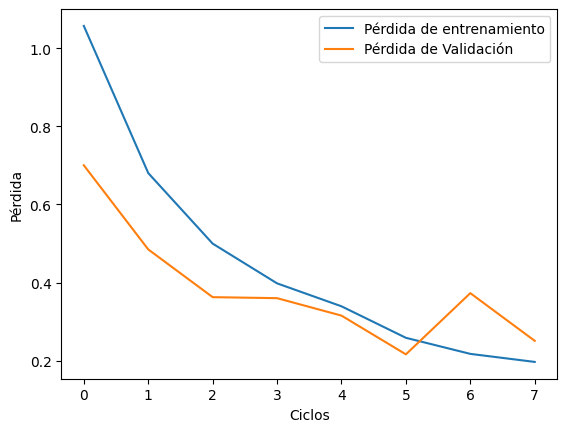

In [44]:
# Plot training vs validation loss
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.xlabel('Ciclos')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

36/36 ━━━━━━━━━━━━━━━━━━━━ 18s 496ms/step
Test Evaluation Accuracy: 0.9155555555555556
Weighted F1 Score: 0.9160249612376924


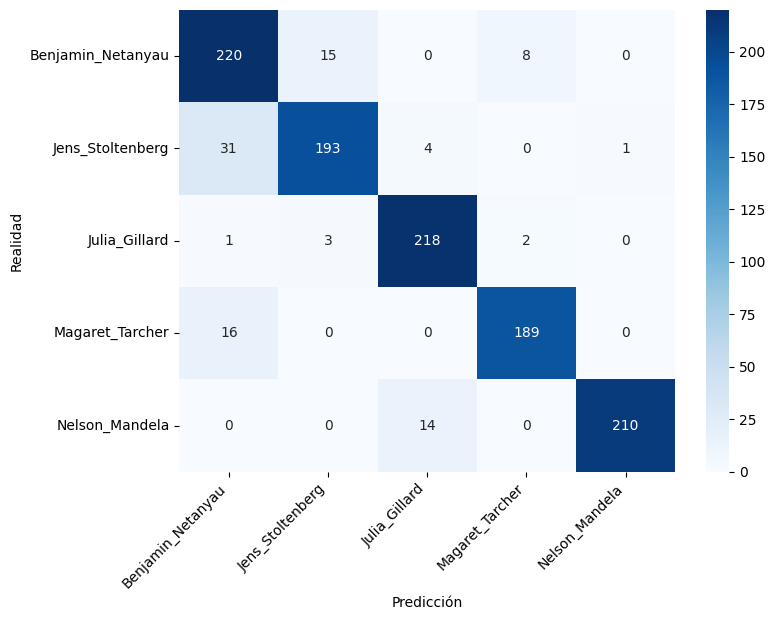

In [45]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

# Evaluate the model on the test set
y_pred_probabilities = model.predict(X_test)
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Decode labels back to original format
y_test_decoded = label_encoder.inverse_transform(y_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded, labels=speaker_folders)

# Calculate accuracy
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"Test Evaluation Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test_decoded, y_pred_decoded, labels=speaker_folders, average='weighted')
print(f"Weighted F1 Score: {f1}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=speaker_folders, yticklabels=speaker_folders)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right")

plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.show()